1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


std default value = 1.2296827044613912


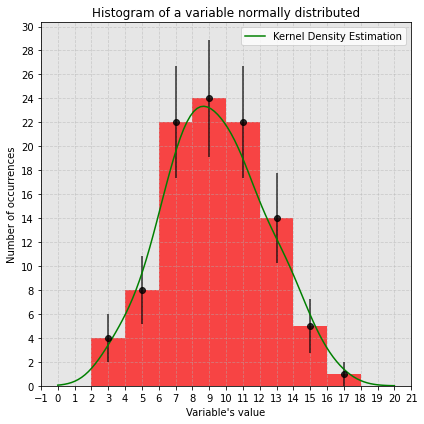

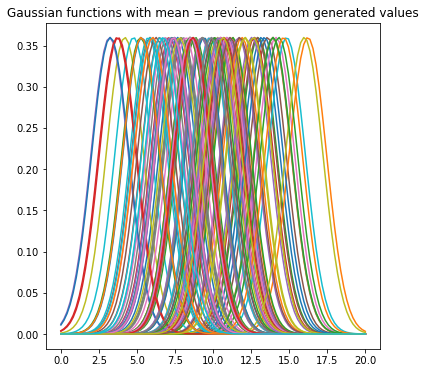

In [134]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
from scipy.stats import norm
from scipy.integrate import trapz
# 1
N = 100
mu = 10
sigma = 3
rng = npr.default_rng()
x = rng.normal(mu, sigma, N)
# 2
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
plt.grid(linestyle='--', alpha=0.5)
ax.set_title("Histogram of a variable normally distributed")
n_bins = 10
n, bins, patches = plt.hist(x, bins=n_bins, range=(0,20), color="red", alpha=0.7)
poiss = np.sqrt(n)
bins_center = (bins[:-1]+bins[1:]) / 2
# Avoiding plotting empty bins
bins_center = bins_center[n != 0]
n = n[n != 0]; poiss = poiss[poiss !=0]
plt.errorbar(bins_center, n, yerr=poiss, fmt="o", color="k", alpha=0.8)
ax.set_xlabel("Variable's value")
ax.set_ylabel("Number of occurrences")
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.set_facecolor((.9,)*3)
plt.tight_layout()
# 3
std_standard = 1.06 * x.std() * x.size**(-1/5)
print(f"std default value = {std_standard}")
x_plot = np.linspace(0,20,100)
def gauss(mean, std=std_standard):
    x = x_plot
    # Not necessary putting all parameters if we're scaling afterwards
    y = 1/np.sqrt(2*np.pi*std)*np.exp(-(x-mean)**2/(2*std**2))
    return y
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
for m in x:
    ax2.plot(x_plot, gauss(m))
ax2.set_title("Gaussian functions with mean = previous random generated values")
# 4
M = np.zeros((x.shape[0], 100))
for i in range(x.shape[0]):
    M[i] = gauss(x[i])
M_sum = np.sum(M, axis=0)
I = x.sum()
I_M_sum = trapz(M_sum)
M_sum = M_sum / I_M_sum * I
ax.plot(x_plot, M_sum, color="green", label="Kernel Density Estimation")
_ = ax.legend()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

(500, 5, 2)
Categories chosen: 3, 5


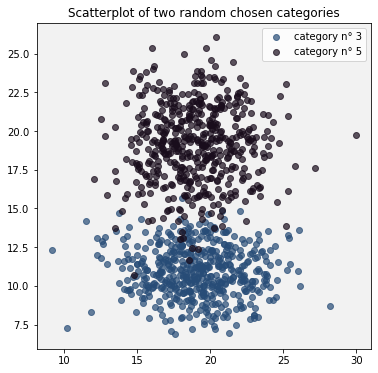

In [265]:
import numpy as np
import numpy.random as npr
from numba import jit, prange
import matplotlib.pyplot as plt
# numpy.random.default_rng() isn't currently supported by numba
#rng = npr.default_rng()

@jit
def gen(N=100, n_categories=2):
    M = np.zeros((N, n_categories, 2))
    means = npr.randint(10, 20, (n_categories,2))
    stds = npr.uniform(1, 3, (n_categories,2))
    for j in prange(n_categories):
        M[:,j,0] = npr.normal(means[j,0], stds[j,0], N)
        M[:,j,1] = npr.normal(means[j,1], stds[j,1], N)
    return M

N = 500
n_categories = 5
data = gen(N, n_categories)
print(data.shape)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
c1 = "#274C77" # blue navy
c2 = "#190D1C" # xiketic
cat1 = npr.randint(n_categories)
cat2 = npr.randint(n_categories)
while cat2 == cat1:
    cat2 = npr.randint(n_categories)
if cat2 < cat1:
    cat1, cat2 = cat2, cat1
print(f"Categories chosen: {cat1+1}, {cat2+1}")
plt.scatter(data[:,cat1,0], data[:,cat1,1], color=c1, alpha=0.7, label=f"category n° {cat1+1}")
plt.scatter(data[:,cat2,0], data[:,cat2,1], color=c2, alpha=0.7, label=f"category n° {cat2+1}")
ax.set_facecolor((.95,)*3)
ax.set_title("Scatterplot of two random chosen categories")
_ = ax.legend()

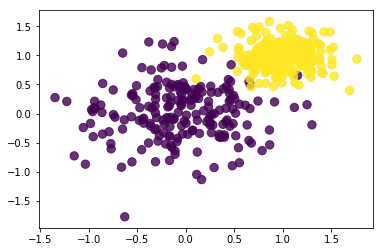

In [2]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

       residuals  distances
0       1.100000       16.0
1      -1.950000        6.3
2      -7.200000        3.4
3      -4.150000        8.4
4      -6.590000        1.7
...          ...        ...
11126  -0.760000       14.4
11127   0.380000        7.5
11128   0.083333        1.7
11129   0.166667       19.1
11130   0.083333        2.6

[11131 rows x 2 columns]


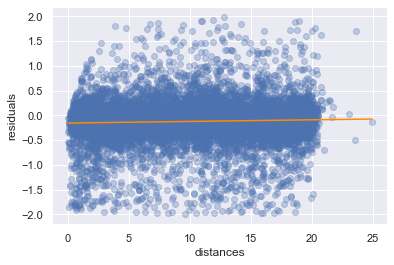

<Figure size 432x288 with 0 Axes>

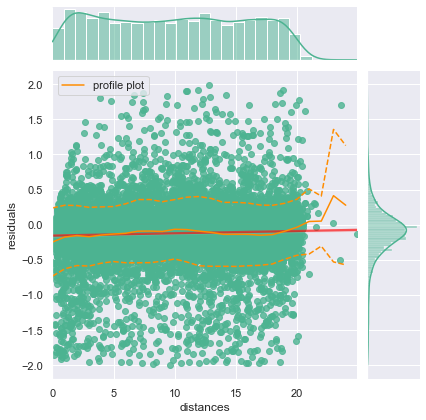

In [367]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
filename = "residuals_261.npy"
df = pd.DataFrame(np.load(filename, allow_pickle=True).item())
print(df)
f1, f2 = "residuals", "distances"
df = df[np.abs(df[f1]) < 2]
# Fitting
x, y = df[f2], df[f1]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(x, y, alpha=0.3)
X = np.linspace(x.min(),x.max(),2)
Y = slope*X + intercept
ax.plot(X,Y, color="darkorange")
plt.xlabel(f2)
plt.ylabel(f1)
plt.figure()
j = sns.jointplot(x=x, y=y, kind="reg", color="#4CB391", line_kws={"color":"red", "alpha":0.6})
# Numpy part
x = np.arange(-1, 25, 1) # bin centers for the "distance" variable
y = np.zeros(x.shape) # mean values of the "residuals", estimated in slices (bins) of "distance"
for i in range(y.shape[0]):
    y[i] = np.mean(df[ (df[f2] >= x[i]-1) & (df[f2] < x[i]+1) ][f1])
erry = np.zeros(y.shape) # standard deviation of the "residuals", estimated in slices (bins) of "distance"
for i in range(y.shape[0]):
    erry[i] = np.std(df[ (df[f2] >= x[i]-1) & (df[f2] < x[i]+1) ][f1])
plt.plot(x, y, color='darkorange', label='profile plot')
plt.plot(x, y+erry, '--', color='darkorange')
plt.plot(x, y-erry, '--', color='darkorange')
_ = plt.legend()